## Putting it all together 

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
data = pd.read_csv("car-sales-extended-missing-data.csv")
data.dropna(subset = ["Price"], inplace= True)
data


categorical_features =["Make", "Colour"]

categorical_transformer = Pipeline (steps= [ # steps is a list containing tuples
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown= "ignore"))
    ## If set to "error" (default), it will crash when it encounters an unknown category.
    ## If set to "ignore", it will just skip it and output all zeros for that column.
])

door_features =["Doors"]

door_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value= round(np.mean(data["Doors"])))), # takes the mean and fills
    ##the door NAN coloumns with 4
])

numeric_features = ["Odometer (KM)"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

# set up preprocessing steps (fill missing values then convert coloumns to number)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("door", door_transformer, door_features ),
        ("num", numeric_transformer, numeric_features)
    ], 
    n_jobs=-1,
)

model = Pipeline(steps =[
    ("Preprocessor", preprocessor),
    ("model", RandomForestRegressor())
])

#split data
x = data.drop("Price", axis=1)
y = data["Price"]
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.2)
error_score="raise"


model.fit(x_train, y_train)
model.score(x_test, y_test)



 


0.22188417408787875

In [3]:
#use GrideSearchCV with our regression Pipeline
pipe_grid = {
    "Preprocessor__num__imputer__strategy" : ["mean", "median"],
    "model__n_estimators": [100, 500],
    "model__max_depth": [None, 5],
    "model__max_features": ["sqrt", "log2", None],
    "model__min_samples_split": [2, 4]
    
    
}


gs_model = GridSearchCV(model, pipe_grid, cv=5 , verbose =2)
gs_model.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   1.6s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   0.1s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   0.1s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   0.1s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   0.1s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Make',
                                                                          'Colour']),
                                                                        ('door',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=4,
                                                                                                        strategy='constant'))]),
                                                                         ['Doors']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Odometer '
                                                                          '(KM)'])])),
                                       ('model', RandomForestRegressor())]),
             param_grid={'Preprocessor__num__imputer__strategy': ['mean',
                                                                  'median'],
                         'model__max_depth': [None, 5],
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_split': [2, 4],
                         'model__n_estimators': [100, 500]},
             verbose=2)

In [4]:
gs_model.best_params_

{'Preprocessor__num__imputer__strategy': 'mean',
 'model__max_depth': 5,
 'model__max_features': 'log2',
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [5]:
y_preds= gs_model.predict(x_test)
y_preds[:10]

array([17967.70342939, 20142.69925218, 11870.47672515, 11090.3749137 ,
       11225.24780976, 13145.47249816, 15801.94468062, 12900.1025027 ,
       18169.76814522, 14287.23262483])

In [6]:
y_test[:10]

203    10547.0
979    17940.0
729    12950.0
838     5905.0
919     9826.0
601    11162.0
865    13650.0
974    14345.0
509    12024.0
178    10076.0
Name: Price, dtype: float64

In [7]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_preds)
print("R² Score:", r2)

gs_model.score(x_test, y_test)

R² Score: 0.296420611896301


0.296420611896301

In [8]:
round(np.mean(data["Doors"]))

4

In [9]:
clf = RandomForestRegressor()
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [10]:
data.dtypes


Make              object
Colour            object
Odometer (KM)    float64
Doors            float64
Price            float64
dtype: object

In [11]:
data.isna().sum()

Make             47
Colour           46
Odometer (KM)    48
Doors            47
Price             0
dtype: int64

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay,ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [13]:
df = pd.read_csv("heart-disease.csv")
df


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Exploratory data analysis (EDA)
the goal here is to find our more abour the data and beome a subject matter expert 
1. where are the outliers and why we should care about them 
2. What questions are you trying to solve or raise
3. what's missing from the data and how do you deal with it
4. How can you add , change or removce feature to get more out of the data
5. what kind of data do we have and how do we treat different types ?

In [15]:
df["target"].value_counts()

target
1    165
0    138
Name: count, dtype: int64

<Axes: xlabel='target'>

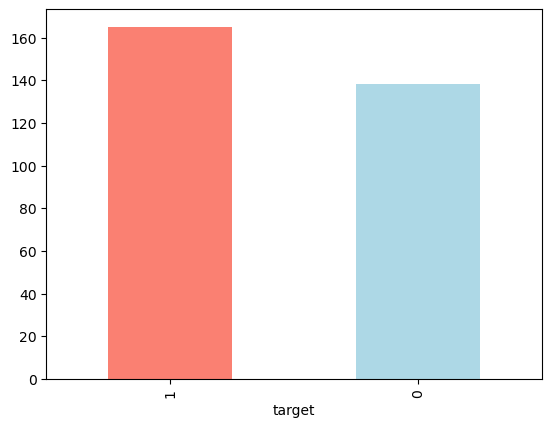

In [16]:
df["target"].value_counts().plot(kind= "bar", color =["salmon","lightblue"])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [18]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [19]:
df.describe()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [20]:
# compare the coloumns to the target
df.sex.value_counts()

sex
1    207
0     96
Name: count, dtype: int64

In [21]:
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


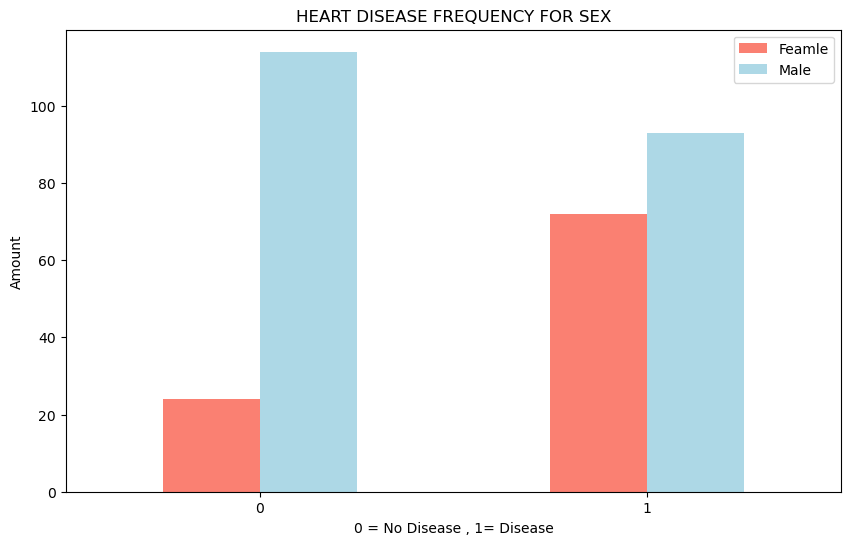

In [22]:
pd.crosstab(df.target, df.sex).plot(kind="bar", figsize=(10,6), color =["salmon","lightblue"])
 
plt.title("HEART DISEASE FREQUENCY FOR SEX")
plt.xlabel("0 = No Disease , 1= Disease")
plt.ylabel("Amount")
plt.legend(["Feamle", "Male"])
plt.xticks(rotation = 0);

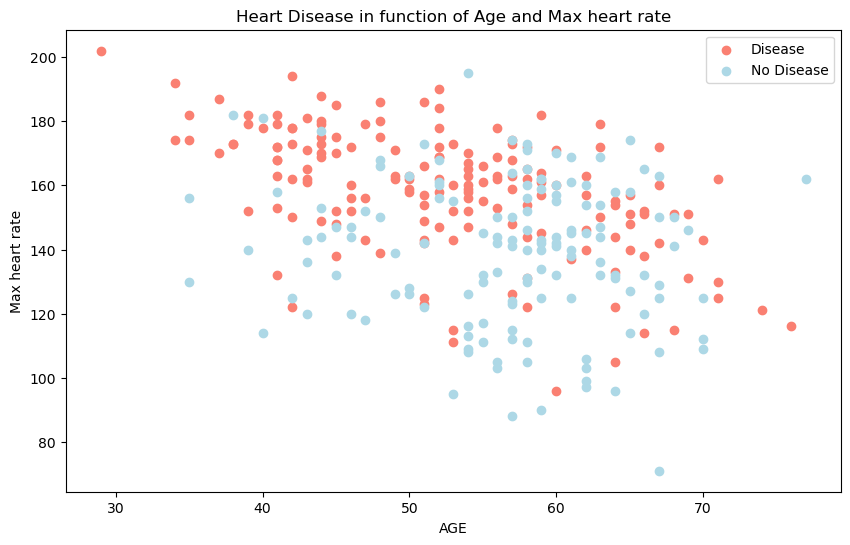

In [23]:
plt.figure(figsize=(10, 6))

plt.scatter(df.age[df.target ==1], 
           df.thalach[df.target ==1],
           c ="salmon")

plt.scatter(df.age[df.target ==0], 
           df.thalach[df.target ==0],
           c ="lightblue");

plt.xlabel("AGE")
plt.ylabel("Max heart rate")
plt.title("Heart Disease in function of Age and Max heart rate")
plt.legend(["Disease", "No Disease"]);


In [24]:
## the younger someone is the higher their heart-rate

<Axes: ylabel='Frequency'>

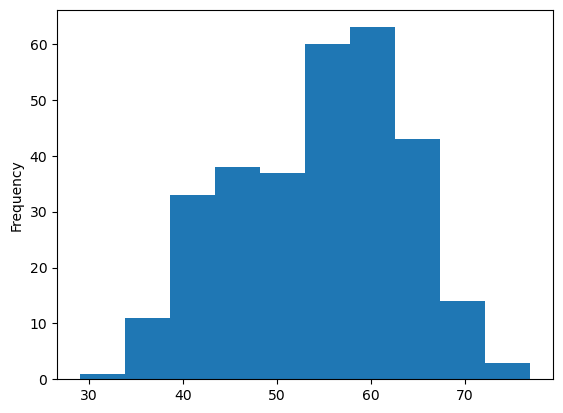

In [25]:
# check the distribution of the age coloumn with a histogram
df.age.plot.hist()

In [26]:
## heart disease frequency  per chest pain type 
pd.crosstab(df.cp,df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


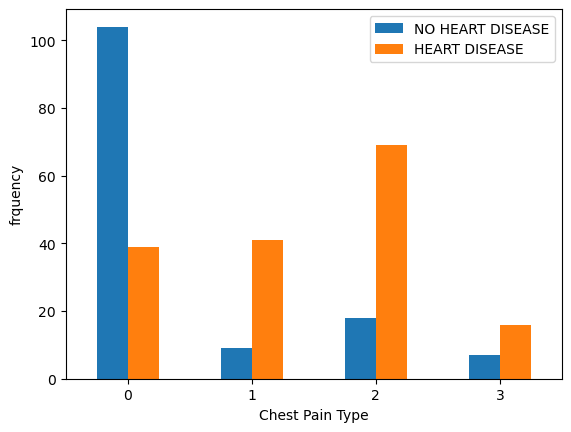

In [27]:
pd.crosstab(df.cp,df.target).plot(kind="bar", )
plt.legend(["NO HEART DISEASE","HEART DISEASE"])
plt.ylabel("frquency")
plt.xlabel("Chest Pain Type")
plt.xticks(rotation = 0);



In [28]:
## More heart disease noted in the nuber 2 when it statess it's non heart related spasm chest pain type

In [29]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


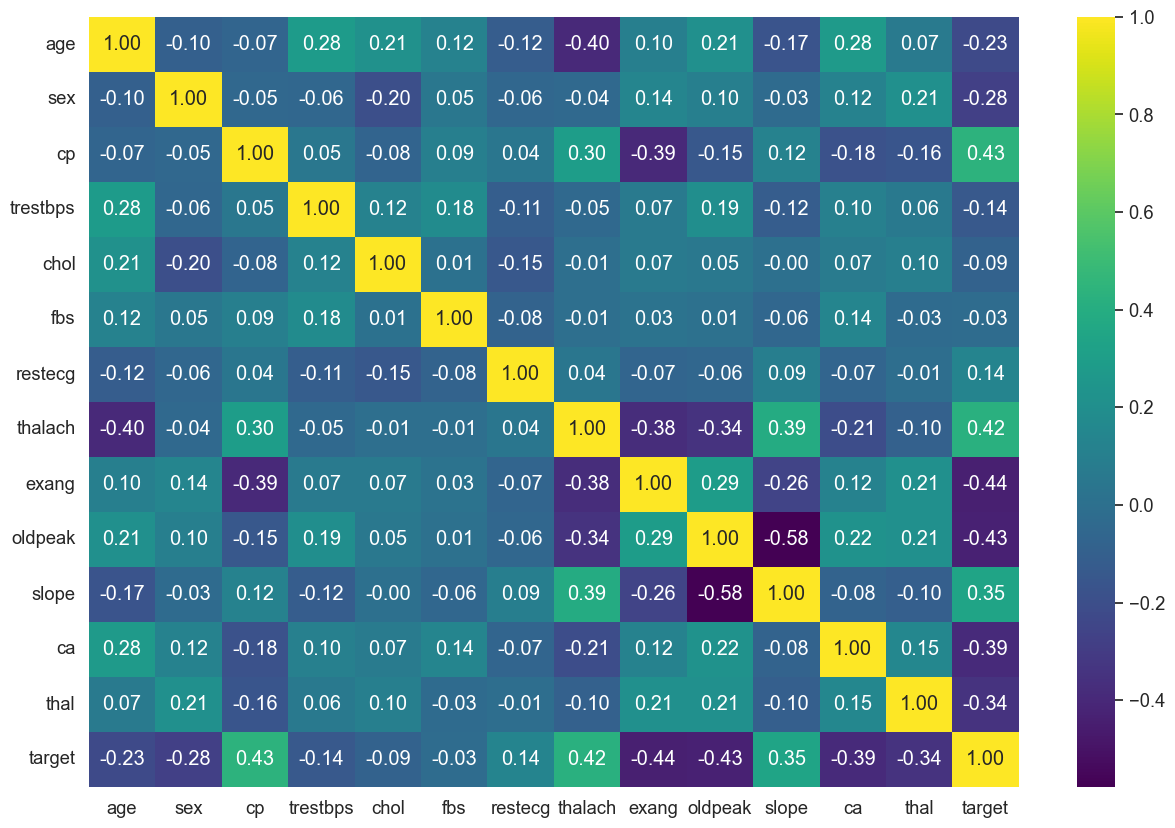

In [30]:
import seaborn as sns
sns.set(font_scale = 1.2)

corr_matrix = df.corr()

fig, ax = plt.subplots(figsize= (15, 10))

ax = sns.heatmap(corr_matrix, annot=True, fmt= ".2f", cmap ="viridis" ); 


#a higher positive value has as  potentisal positive colleration (as cp goes up the target values also increases)
#Negative correlation ( a relationship between two variables in which one variable increases and the other 
# decreases)

# 5. Modelling

In [32]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [33]:

x= df.drop("target", axis = 1)
y= df["target"]

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.2)

models = {"RFC": RandomForestClassifier(),
          "KNN": KNeighborsClassifier(),
          "LR": LogisticRegression(max_iter=500)
}

def  fit_and_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evalutes given machine learning models.
    models: a dict of different Sklearn machine learning models
    """
    model_scores = {}
    np.random.seed(42)
    for name, model in models.items(): # gets the values in the dictionary
        model.fit(x_train,y_train)
        #creates a key name/appends the model name and score in the model_Score dictionary
        model_scores[name] = model.score(x_test, y_test) #sets the score as the dictionary name
    return model_scores



In [34]:
models_scores = fit_and_score(models = models,
                            x_train =x_train,
                            x_test= x_test,
                            y_train = y_train,
                            y_test =y_test)
models_scores

C:\Users\EZEEN\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'RFC': 0.8360655737704918,
 'KNN': 0.6885245901639344,
 'LR': 0.8688524590163934}

,accuracy
RFC,0.836066
KNN,0.688525
LR,0.868852


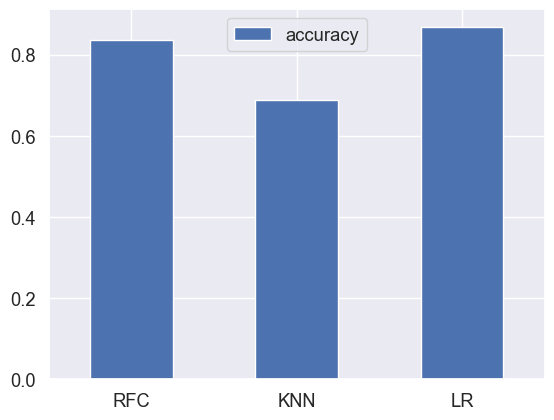

In [35]:
model_compare = pd.DataFrame(models_scores, index = ["accuracy"])
model_compare.T.plot.bar();# transpose it to ge the right graph because if you don't the first axis0 would
# be taken as x axis in the graph while the coloumns would be taken as the legend
plt.xticks(rotation = 0);
model_compare.T


In [36]:
# clf3.get_params()

In [37]:
df


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [38]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df = scaler.fit_transform(df)
# df = pd.DataFrame(df)
# df.describe().round(2)

In [39]:
df


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [40]:
model = KNeighborsClassifier()
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [41]:
train_scores = []
test_scores =[]

neighbors = range(1, 21)

knn = KNeighborsClassifier()
for i in neighbors:
    knn.set_params(n_neighbors = i )
    knn.fit(x_train, y_train)
    train_scores.append(round(knn.score(x_train, y_train) * 100, 2))
    test_scores.append(round(knn.score(x_test,y_test)*100, 2))
train_scores



[100.0,
 80.99,
 77.27,
 74.38,
 76.03,
 75.21,
 74.38,
 72.31,
 71.9,
 69.42,
 72.73,
 69.83,
 69.01,
 69.42,
 68.6,
 67.36,
 68.6,
 66.53,
 68.18,
 66.94]

In [42]:
test_scores

[62.3,
 63.93,
 65.57,
 67.21,
 68.85,
 72.13,
 70.49,
 68.85,
 68.85,
 70.49,
 75.41,
 73.77,
 73.77,
 73.77,
 68.85,
 72.13,
 68.85,
 68.85,
 70.49,
 65.57]

Maximum score of test set is: 75.41%


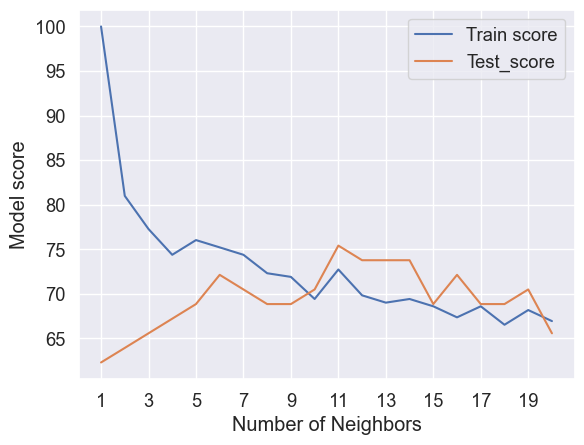

In [43]:
plt.plot(neighbors, train_scores)
plt.plot(neighbors, test_scores)
plt.xlabel("Number of Neighbors")
plt.ylabel("Model score")
plt.legend(["Train score","Test_score"])
plt.xticks(np.arange(1,21, 2)) #1-21 with a space of 2

print(f"Maximum score of test set is: {max(test_scores)}%")


In [44]:
model = LogisticRegression()
model2 = RandomForestClassifier()
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [45]:
np.logspace(-4, 4, 20)

array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])

In [46]:
from sklearn.model_selection import RandomizedSearchCV
log_reg_grid = {"C": np.logspace(-4, 4, 20 ), # random 20 numbers number with  x 10 ^-4 to x 10 ^ 4
           "solver": ["liblinear"]} 

rf_grid ={
    "n_estimators": np.arange(10,1000, 50),
     "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2)
         }

np.random.seed(42)
rs_log_reg = RandomizedSearchCV(LogisticRegression(), 
                                param_distributions= log_reg_grid,
                                n_iter= 20, cv= 5, n_jobs= -1, verbose=2
                               )
rs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=2)

In [47]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [48]:
rs_log_reg.score(x_test, y_test)

0.8852459016393442

In [49]:
np.random.seed(42)
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                                param_distributions= rf_grid,
                                n_iter= 20, cv= 5, n_jobs= -1, verbose=2
                               )
rs_rf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=2)

In [50]:
rs_rf.best_params_ 

{'n_estimators': 560,
 'min_samples_split': 16,
 'min_samples_leaf': 17,
 'max_depth': 5}

In [51]:
rs_rf.score(x_test, y_test)

0.8688524590163934

In [52]:
gs_log_reg = GridSearchCV(LogisticRegression(), 
                                param_grid= log_reg_grid,
                                cv= 5, n_jobs= -1, verbose=2
                               )
gs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=2)

In [53]:
gs_log_reg.score(x_test, y_test) # done very well

0.8852459016393442

## Evaluting our tuned machine learning model

In [55]:
y_preds = gs_log_reg.predict(x_test)

In [56]:
y_preds

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [57]:
y_test

179    0
228    0
111    1
246    0
60     1
      ..
249    0
104    1
300    0
193    0
184    0
Name: target, Length: 61, dtype: int64

In [58]:
pd.crosstab(y_test, y_preds)

col_0,0,1
target,,
0,25,4
1,3,29


Roc curves are a comparison of a model's `true positiive rate (tpr)` versus a models `false positive rate (fpr)`

* True Positve = model prdicts 1 when truth is 1
* False Positive = model predicts 1 when truth is 0
* True Negative = model predicts 0 when truth is 0
* False Negative = model predits 0 when truth is 1


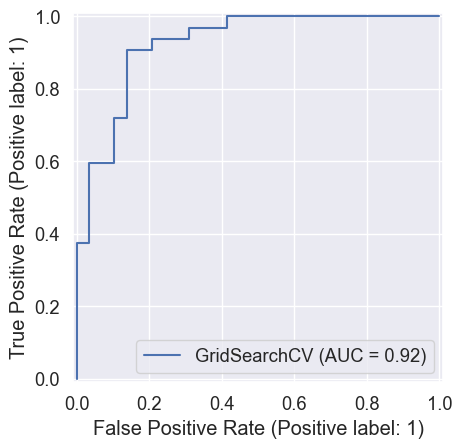

In [60]:
RocCurveDisplay.from_estimator(gs_log_reg, x_test, y_test)


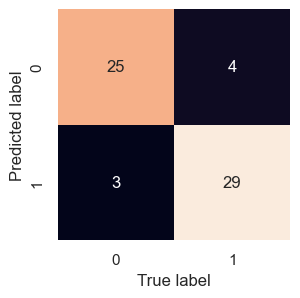

In [61]:
sns.set(rc={"font.size": 12}); #runtime configuration / or use font_scale =
def plot_conf_max(y_test, y_preds):
    """
    Plot a nice looking confusion matric using seaborn
    """
    fig, ax = plt.subplots(figsize =(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds) , annot= True,cbar = False);
    plt.xlabel("True label")
    plt.ylabel("Predicted label")

plot_conf_max(y_test, y_preds)


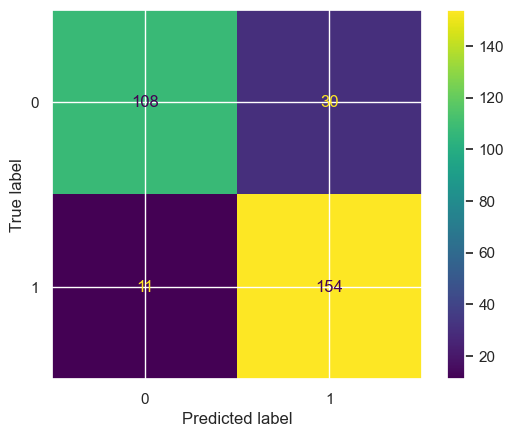

In [62]:
ConfusionMatrixDisplay.from_estimator(estimator=gs_log_reg, X=x, y=y)

In [63]:

# Avoid overwriting built-in 'dict'
scoring_dict = {
    "Accuracy": "accuracy",
    "Recall": "recall",
    "Precision": "precision",
    "F1": "f1"
}

def cross_val(clf, x, y):
    """
    Calculates cross-validation scores for different metrics.
    Returns a dictionary of metric names and their average scores.
    """
    output = {}
    for name, score_type in scoring_dict.items():
        scores = cross_val_score(clf, 
                                 x, 
                                 y,
                                 cv=5, 
                                 scoring=score_type)
        output[name] = round(np.mean(scores), 2)*100
    return output

# Example usage:
clf = LogisticRegression(C=0.23357214690901212, solver="liblinear")
results = cross_val(clf, x, y)
print(results)


{'Accuracy': 85.0, 'Recall': 93.0, 'Precision': 82.0, 'F1': 87.0}


In [64]:
result_df = pd.DataFrame([results], index = None)  # Wrap in list = one row
print(result_df)

   Accuracy  Recall  Precision    F1
0      85.0    93.0       82.0  87.0


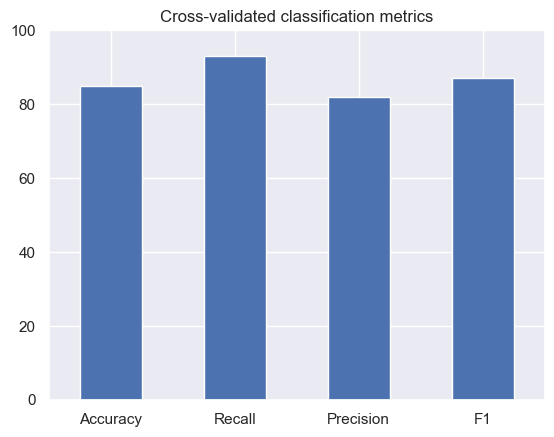

In [65]:
result_df.T.plot.bar(title ="Cross-validated classification metrics", legend = False )
plt.xticks(rotation = 0)
plt.ylim(0, 100);

## FEATURE IMPORTANCE
which features contributed most to the outcomes of the model and how did they contribute?"

In [67]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [68]:
gs_log_reg.best_params_

{'C': 0.23357214690901212, 'solver': 'liblinear'}

In [69]:
clf = LogisticRegression(C =0.23357214690901212 , solver ="liblinear")
clf.fit(x_train, y_train)

LogisticRegression(C=0.23357214690901212, solver='liblinear')

In [70]:
clf.coef_[1] # independate coloumns/variables

IndexError: index 1 is out of bounds for axis 0 with size 1

In [76]:
df.shape

(303, 14)

In [77]:
## corefficient  of importance/ feature impprtance
feature_dict = dict(zip(df.columns, list(clf.coef_[0]))) #So clf.coef_[0] gives 
#the list of weights for the first (and only) class, because the coef_ is in the shape(1, n_features).
# zip puts two lists in a multiplicable tuple formate
feature_dict

{'age': 0.003699221627279003,
 'sex': -0.9042409285687546,
 'cp': 0.6747282509574564,
 'trestbps': -0.01161340025062118,
 'chol': -0.0017036437710376048,
 'fbs': 0.047876877336918186,
 'restecg': 0.33490200716536156,
 'thalach': 0.024729382362283066,
 'exang': -0.6312040866990564,
 'oldpeak': -0.5759096490530667,
 'slope': 0.47095148586396174,
 'ca': -0.6516534633333719,
 'thal': -0.6998421076294032}

In [78]:
df


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


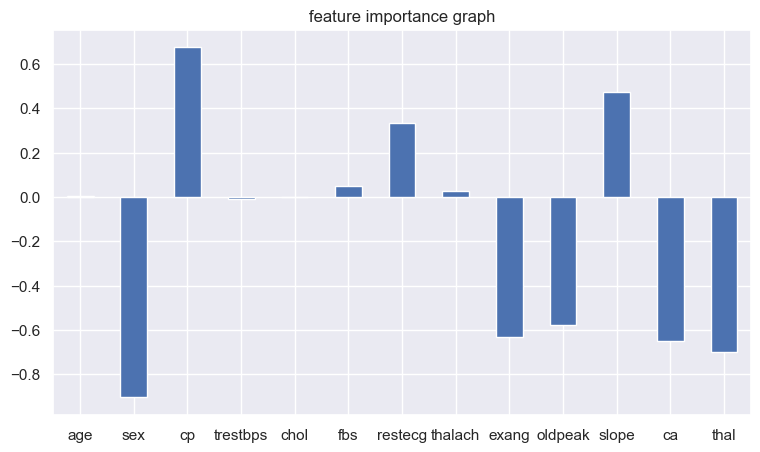

In [79]:
feature_df = pd.DataFrame(feature_dict, index =[0])
feature_df.T.plot(kind = "bar", legend = None, title = "feature importance graph", figsize= (9,5));
plt.xticks(rotation = 0);

## WHAT DO NOT HAVE A NEGATIVE OR POSITIVE COEFFICIENT VALUE?
`age`,
`trestbps`,
`chol`

In [81]:
pd.crosstab(df.slope,df.target)

target,0,1
slope,,
0,12,9
1,91,49
2,35,107


In [82]:
import requests

url = 'https://github.com/mrdbourke/zero-to-mastery-ml/raw/master/data/bluebook-for-bulldozers.zip'
response = requests.get(url)

with open('bluebook-for-bulldozers.zip', 'wb') as f:
    f.write(response.content)

import os
import zipfile

local_zip = 'bluebook-for-bulldozers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('.') # extract all data into current working directory
zip_ref.close()

In [83]:
import os

# List the files in the current directory
for file in os.listdir('.'): # "." current directroy
    print(file)


.git
.gitignore
.ipynb_checkpoints
21CG029853_431ASSIGNMENT (2).pdf
21CG029853_431ASSIGNMENT.pdf
6-step-ml-framework.png
Agentic AI Pioneer Program Projects.pdf
bluebook-for-bulldozers
bluebook-for-bulldozers.zip
car-sales-extended-missing-data.csv
car-sales-extended.csv
car-sales-missing-data.csv
car-sales-missing-dropped.csv
car-sales.csv
exported-car-sales-shuffled.csv
exported-car-sales.csv
gs_random_forest_model.joblib
gs_random_forest_model.pk1
heart-disease-analysis-plot-saved-with-code.png
heart-disease.csv
images
init.htm
Introduction-to-pandas.ipynb
irisflower-prediction-main.zip
MACHINE-LEARNING-101.ipynb
magic04.data
Matplotlib.ipynb
ML-PROJECTS
New-ML.ipynb
Numpy.ipynb
random_forest_model_1.pk1
scikit-learn-data.zip
scikit-learn-what-were-covering.ipynb.txt
Sklearn-algorithm-cheat-sheet.png
Sklearn.ipynb
Sklearn2.0.ipynb
Sklearn3.0.ipynb


In [84]:
df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False) # store it howerever don't try to minimise the amount of space

In [85]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

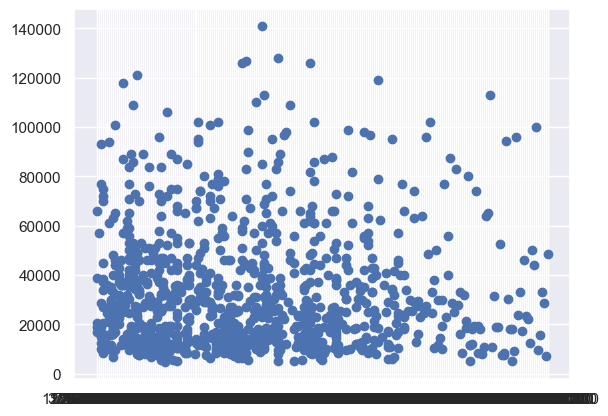

In [87]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

<Axes: ylabel='Frequency'>

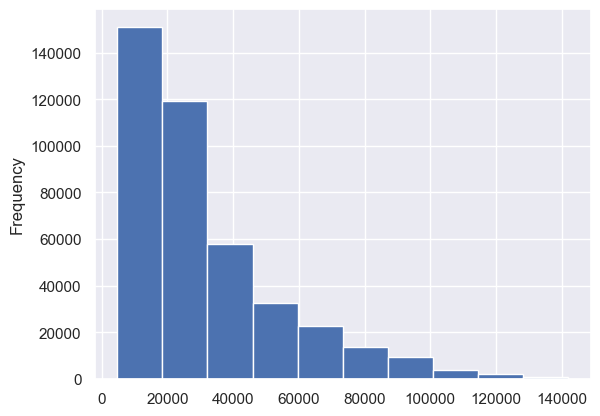

In [88]:
df.SalePrice.plot.hist()

In [89]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Parsing Dates
we can do that by telling pandas which of our coloumns has dates in it 

In [91]:
 df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False, # store it howerever don't try to minimise the amount of space
                 parse_dates=["saledate"])# datetime64[ns] = <M8[ns] -- conerts the saledate coloumn to a datetime dtype


In [92]:
df.saledate.dtype

dtype('<M8[ns]')

In [93]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

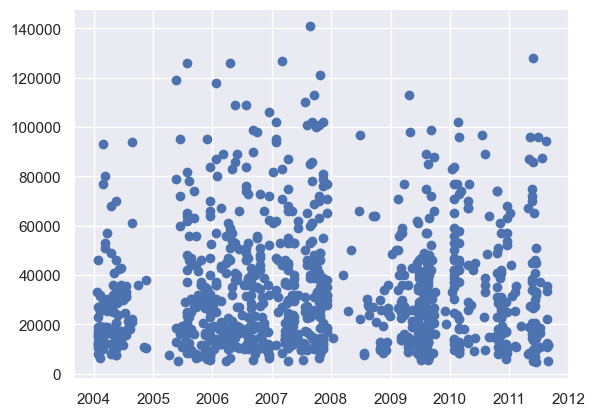

In [94]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])


In [95]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

### sort dataframe by sale_date (time series problem)
* when working with timeseires it's a good idead to sort by date

In [97]:
df.sort_values(by =["saledate"], 
                          ascending=True, inplace= True,
                          na_position= "last",ignore_index= True)

In [98]:
df_tmp = df.copy()

In [99]:
df_tmp.saledate

0        1989-01-17
1        1989-01-31
2        1989-01-31
3        1989-01-31
4        1989-01-31
            ...    
412693   2012-04-28
412694   2012-04-28
412695   2012-04-28
412696   2012-04-28
412697   2012-04-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

In [100]:

df_tmp["saleYear"] = df_tmp[:1].saledate.dt.year

# Get specific datetime parameters for `saledate` coloumn 

In [102]:
df_tmp[:1].saledate.dt.year, df_tmp[:1].saledate.dt.day # use the datetime function for feature engineering  

(0    1989
 Name: saledate, dtype: int32,
 0    17
 Name: saledate, dtype: int32)

In [103]:
df_tmp["saleday"] = df_tmp.saledate.dt.day
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saledayofweek"] = df_tmp.saledate.dt.day_of_week
df_tmp["saledayofyear"] = df_tmp.saledate.dt.day_of_year


In [104]:
df_tmp.head().T


,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [105]:
df_tmp.state.value_counts(ascending= True)

state
Washington DC         2
Puerto Rico          42
Rhode Island         83
Hawaii              118
South Dakota        244
Vermont             300
Massachusetts       347
Alaska              430
North Dakota        480
Delaware            510
Kansas              667
West Virginia       840
Nebraska            866
Oklahoma           1326
Montana            1336
Iowa               1336
Wyoming            1672
Michigan           1831
Oregon             1911
Idaho              2025
Virginia           2353
New Hampshire      2738
Wisconsin          2745
Unspecified        2801
Utah               3046
New Mexico         3631
Arkansas           3933
Indiana            4124
Maine              5096
Kentucky           5351
Louisiana          6627
Nevada             6932
Missouri           7178
Minnesota          7885
Connecticut        8276
New York           8639
Arizona            9364
South Carolina     9951
Pennsylvania      10234
Alabama           10292
Tennessee         10298
North Caro

In [106]:
df_tmp["Grouser_Type"].value_counts(ascending= True)

Grouser_Type
Single        2
Triple    15193
Double    86998
Name: count, dtype: int64

the Machine ID is redndant but the Year Made has a positive correlation with the sales price 


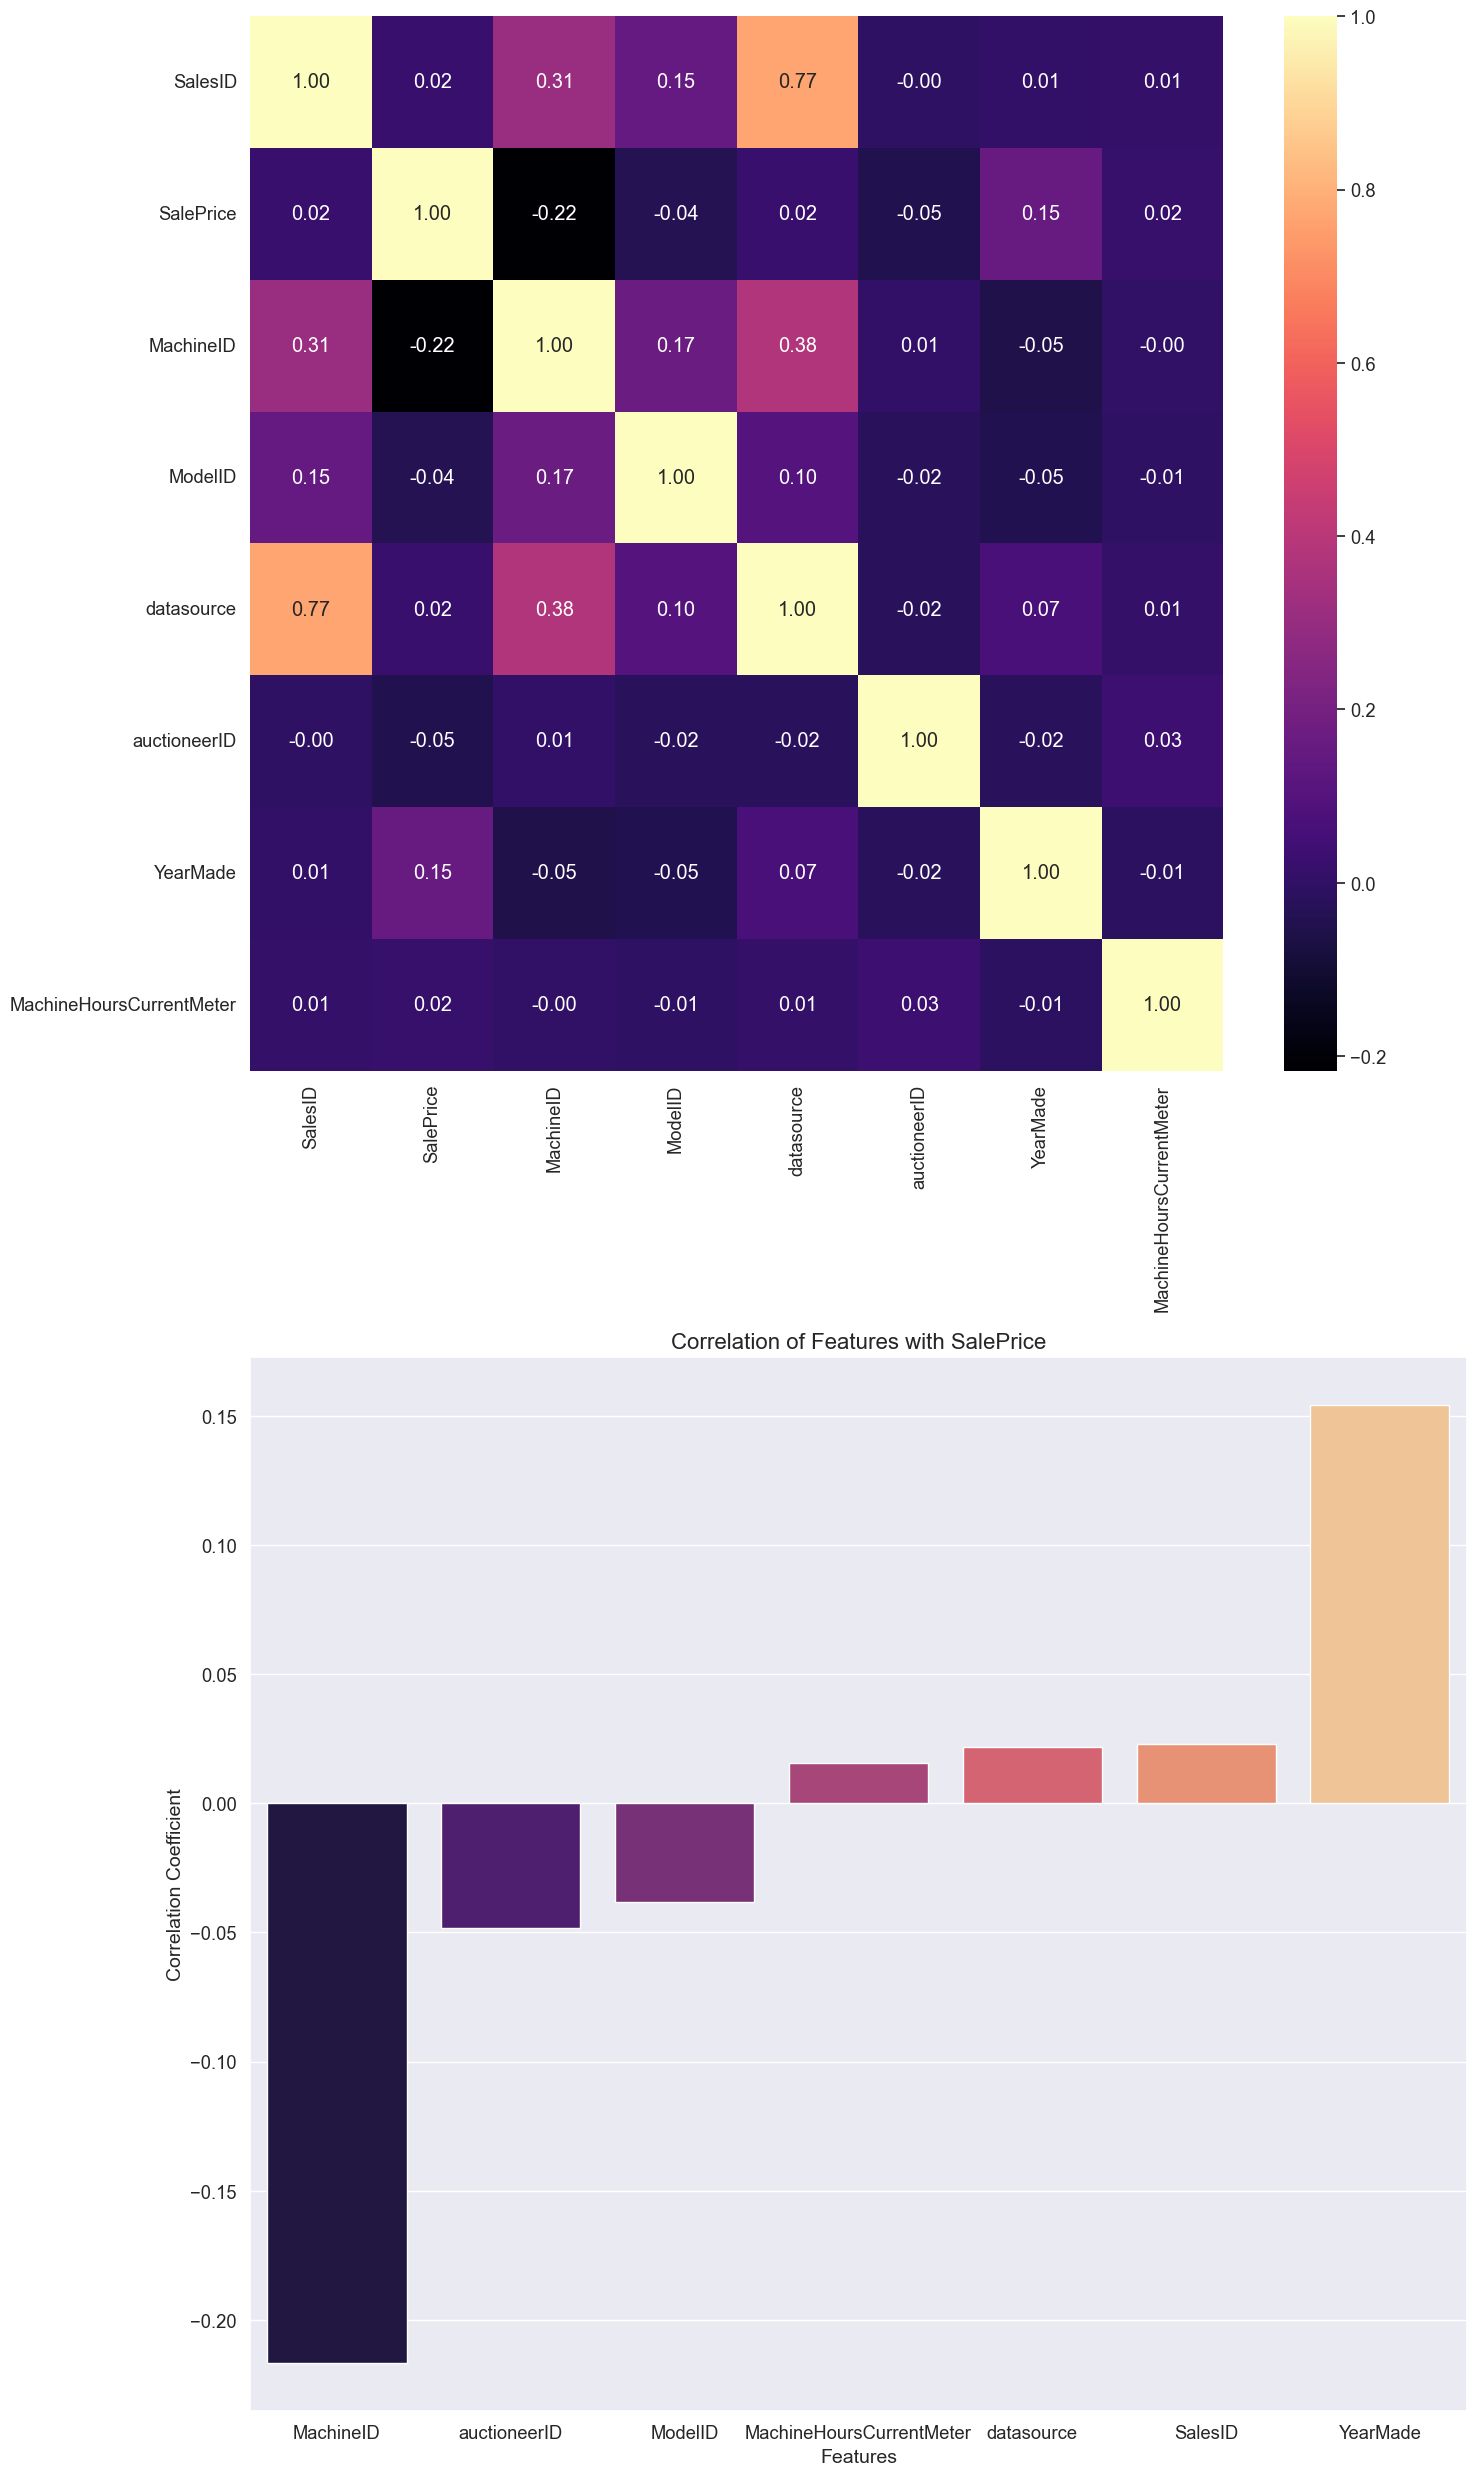

In [107]:
import warnings
warnings.filterwarnings('ignore')  ## gets rid of warning


# Keep only numeric columns
df_numeric = df_tmp.select_dtypes(include=["int64", "float64"])

# Now compute the correlation matrixb
corr_matrix = df_numeric.corr()
# Assuming your target variable is 'SalePrice'
target = "SalePrice"

# Get correlation of features with target variable
corr_with_target = corr_matrix[target].drop(target).sort_values()

# Plot it
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.2)
fig, ax = plt.subplots(nrows=2, ncols=1,
                       figsize=(15, 25))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="magma", ax= ax[0])


# Plot bar plot on the second subplot
sns.barplot(y=corr_with_target.values, x=corr_with_target.index, palette="magma", ax=ax[1])


# Customize the bar plot
ax[1].set_title(f"Correlation of Features with {target}", fontsize=16)
ax[1].set_ylabel("Correlation Coefficient", fontsize=14)
ax[1].set_xlabel("Features", fontsize=14)

# Show the plot
plt.tight_layout() # adjusts the spacing of the subplots to avoid overlap

print("the Machine ID is redndant but the Year Made has a positive correlation with the sales price ")





#a higher positive value has as  potentisal positive colleration (as cp goes up the target values also increases)
#Negative correlation ( a relationship between two variables in which one variable increases and the other 
# decreases)

In [108]:
df_tmp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [109]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

False

In [110]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered() #converts to a category
        print(label)
        # then orders the category type content
        
# df.items treats the dataframe as a dictionary where keys are coloumns and values are the content of each columns

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [111]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  category      
 11  fiBaseModel               412698 non-null  category      
 12  fi

In [112]:
df_tmp["Hydraulics"].value_counts()

Hydraulics
2 Valve                145317
Standard               106515
Auxiliary               43224
Base + 1 Function       25511
3 Valve                  5807
4 Valve                  3077
Base + 3 Function         311
Base + 2 Function         132
Base + 5 Function          94
Base + 4 Function          81
Base + 6 Function          54
None or Unspecified        10
Name: count, dtype: int64

In [113]:
df_tmp["Hydraulics"].isna().sum()

82565

## GETS ROWS BASED OF CONTENTS OF A PARTICULAR COLOUMN - Hydraulics coloumn ("None or Unspecified")

In [115]:
#df[...],  When you give df[...] a Series of True/False, 
#pandas returns only the rows where the value is True.

df_hyd = df_tmp[df_tmp["Hydraulics"].str.contains("None or Unspecified", case=False, na = False)]
# "case=" makes it case sensitive, "na=" avoids or accepts NaN values in that coloumn
df_hyd.T

,13851,49061,71156,84161,91988,297781,316984,318516,322380,390919
SalesID,1737063,1732106,1735569,1748403,1748402,1187364,2255559,1147942,2298387,1217461
SalePrice,26500.0,32000.0,12500.0,22000.0,10000.0,39000.0,13000.0,59000.0,26000.0,34000.0
MachineID,1138484,1393321,1321684,1312518,1312518,1021796,1516624,1041701,500386,1021796
ModelID,8991,363,2292,16477,9117,4128,4200,216,4106,13854
datasource,132,132,132,132,132,121,136,121,136,121
auctioneerID,6.0,10.0,2.0,2.0,9.0,3.0,1.0,3.0,1.0,3.0
YearMade,1988,1987,1991,1000,1000,1000,1000,2008,2003,1000
MachineHoursCurrentMeter,1210.0,NaN,NaN,NaN,NaN,5544.0,0.0,1078.0,0.0,16109.0
UsageBand,High,NaN,NaN,NaN,NaN,Low,NaN,High,NaN,Low
saledate,1991-11-05 00:00:00,1996-09-26 00:00:00,1998-10-10 00:00:00,1999-09-25 00:00:00,2000-04-06 00:00:00,2009-03-05 00:00:00,2009-07-30 00:00:00,2009-08-20 00:00:00,2009-09-23 00:00:00,2011-09-15 00:00:00


## GETS ROWS BASED OF CONTENTS OF A PARTICULAR COLOUMN - Hydraulics coloumn ("NaN")

In [117]:
df_NaN = df_tmp[df_tmp["Hydraulics"].str.contains("NaN", case=False, na = True)]
df_NaN.T

,12,24,32,38,53,57,59,61,65,68,...,412660,412664,412665,412673,412676,412678,412679,412681,412684,412685
SalesID,1264985,1259973,1259760,1404057,1265202,1403992,1403368,1403696,1403411,1403418,...,6258767,6259304,6298418,6286556,6286551,6258623,6286233,6319596,6286207,6259091
SalePrice,20000.0,7700.0,8000.0,34000.0,21000.0,26250.0,21500.0,23500.0,23000.0,24000.0,...,27000.0,37000.0,15500.0,23000.0,23000.0,22000.0,24000.0,20500.0,25000.0,26000.0
MachineID,1204499,1150485,1476205,1394594,1385055,561595,1165291,888616,1184544,1390168,...,1797080,1825043,1905393,1793587,1866718,1877704,1932403,1887135,1848914,1789854
ModelID,6788,6788,6788,7110,6788,7110,7110,7110,7110,7110,...,3172,6788,24817,4605,4605,3192,4605,18110,4605,3180
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,99.0,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1984,1978,1978,1987,1984,1986,1985,1986,1986,1986,...,2004,2006,1000,2006,2006,2001,2005,2005,2004,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,...,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00


In [118]:
df_tmp.ProductGroup.cat.categories

Index(['BL', 'MG', 'SSL', 'TEX', 'TTT', 'WL'], dtype='object')

In [119]:
dic = {}
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        dic[label] = list(df_tmp[label].cat.categories)
dic;
            


## This is the percentage of missing data in each coloumn compared to the actual datframe size

In [121]:
round(df_tmp.isna().sum()/ len(df_tmp), 2)*100 

SalesID                      0.0
SalePrice                    0.0
MachineID                    0.0
ModelID                      0.0
datasource                   0.0
auctioneerID                 5.0
YearMade                     0.0
MachineHoursCurrentMeter    64.0
UsageBand                   82.0
saledate                     0.0
fiModelDesc                  0.0
fiBaseModel                  0.0
fiSecondaryDesc             34.0
fiModelSeries               86.0
fiModelDescriptor           82.0
ProductSize                 52.0
fiProductClassDesc           0.0
state                        0.0
ProductGroup                 0.0
ProductGroupDesc             0.0
Drive_System                74.0
Enclosure                    0.0
Forks                       52.0
Pad_Type                    80.0
Ride_Control                63.0
Stick                       80.0
Transmission                54.0
Turbocharged                80.0
Blade_Extension             94.0
Blade_Width                 94.0
Enclosure_

In [122]:
df_tmp.sort_values(by =["saledate"], 
                          ascending=True, inplace= True,
                          na_position= "first",ignore_index= True)


In [123]:
df_tmp[:15]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleday,saleMonth,saledayofweek,saledayofyear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,17,1,1,17
1,1728883,30000.0,1523610,9105,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,1989,31,1,1,31
2,1508502,21000.0,1153157,4138,132,99.0,1972,NaN,NaN,1989-01-31,...,None or Unspecified,Angle,None or Unspecified,NaN,NaN,1989,31,1,1,31
3,1452578,33000.0,1544443,3854,132,99.0,1974,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,31,1,1,31
4,1403418,24000.0,1390168,7110,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,1989,31,1,1,31
5,1453054,36000.0,1117184,3854,132,99.0,1977,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,31,1,1,31
6,1491298,46000.0,1322436,4107,132,99.0,1987,NaN,NaN,1989-01-31,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,1989,31,1,1,31
7,1403411,23000.0,1184544,7110,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,1989,31,1,1,31
8,1263797,17000.0,1526902,6953,132,99.0,1983,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,31,1,1,31
9,1504404,26000.0,1310407,4139,132,99.0,1975,NaN,NaN,1989-01-31,...,None or Unspecified,Angle,None or Unspecified,NaN,NaN,1989,31,1,1,31


In [124]:
## save preprocessed data
df_tmp.to_csv("bluebook-for-bulldozers/train_temp.csv")

In [125]:
df_tmp.YearMade.sort_values(ascending= True)


412697    1000
32883     1000
32885     1000
185463    1000
185460    1000
          ... 
395459    2011
345195    2012
397900    2013
408396    2014
401901    2014
Name: YearMade, Length: 412698, dtype: int64

In [126]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
       print(label)


SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleday
saleMonth
saledayofweek
saledayofyear


In [127]:
df_tmp.ModelID

0          8434
1          9105
2          4138
3          3854
4          7110
          ...  
412693     4605
412694     6868
412695    17231
412696    17231
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [128]:
#check which numeric has null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).any(): # .any() checks if at least one of those values is True. So it returns True:
            print(label)


auctioneerID
MachineHoursCurrentMeter


In [129]:
#fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).any():
            #add a binary coloumn to tells us if the data was missing or not
            df_tmp[label +"_is_missing"] = pd.isnull(content)
            df_tmp[label] = content.fillna(content.median())
            #Fill missing values with mdeian 
x= df_tmp[["auctioneerID","MachineHoursCurrentMeter", "auctioneerID_is_missing","MachineHoursCurrentMeter_is_missing"]].tail()
x


,auctioneerID,MachineHoursCurrentMeter,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
412693,99.0,0.0,False,True
412694,99.0,0.0,False,True
412695,99.0,0.0,False,True
412696,99.0,0.0,False,True
412697,99.0,0.0,False,True


In [130]:
 hundreds = np.full((1000,), fill_value=  100, dtype= "int64")
#(1000,) creates an arrayo of shape 1000 rows and no coloumns -a one dimentioanl array
hundreds_billions = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billions), np.median(hundreds), np.median(hundreds_billions)

(100.0, 999100.8991008991, 100.0, 100.0)

In [131]:
hundreds[:10]

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100], dtype=int64)

In [183]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)


UsageBand
saledate
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [197]:
pd.Categorical(df_tmp["state"]).codes[:10]# pandas categorical type and turn into numbers and get the first 10 values

array([43,  8,  8,  8,  8,  8,  8,  8,  8,  8], dtype=int8)

In [207]:
pd.Categorical(df_tmp["UsageBand"]) #where missing values(NAN) = -1

[NaN, NaN, NaN, NaN, NaN, ..., NaN, NaN, NaN, NaN, NaN]
Length: 412698
Categories (3, object): ['High', 'Low', 'Medium']

In [237]:
df_tmp["UsageBand"]=df_tmp.UsageBand.sort_values(ascending=True,
                          na_position= "first",ignore_index= True)

df_tmp["UsageBand"]

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
412693    Medium
412694    Medium
412695    Medium
412696    Medium
412697    Medium
Name: UsageBand, Length: 412698, dtype: object

In [239]:
pd.Categorical(df_tmp["UsageBand"]).codes[412693:412697] #missing values are recorded as -1

array([2, 2, 2, 2], dtype=int8)

In [251]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content): # gets the non numeric labels
        #Add binary coloumn to indicate whether sample had missing value
        df_tmp[label + "_is_missing"] = pd.isnull(content)# returns True  / False
         # Turn categories into numbers then add +1
        df_tmp[label] = pd.Categorical(content).codes + 1 # turns he catgorical into numbers and then
        #make the missing values 0
        
       

In [245]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 105 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(47), float64(3), int16(5), int32(5), int64(5), int8(40)
memory usage: 71.2 MB


In [247]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500.0,30000.0,21000.0,33000.0,24000.0
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,True
Blade_Type_is_missing,False,True,False,True,True
Travel_Controls_is_missing,False,True,False,True,True
Differential_Type_is_missing,True,True,True,False,True


In [261]:
df_tmp.isna().sum()[:20]

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
saledate                    0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
dtype: int64

Now that all of our data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model

In [270]:
df_tmp.head().T[:20]

,0,1,2,3,4
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500.0,30000.0,21000.0,33000.0,24000.0
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1986,1972,1974,1986
MachineHoursCurrentMeter,0.0,0.0,0.0,0.0,0.0
UsageBand,0,0,0,0,0
saledate,1,2,2,2,2


In [294]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state= 42, n_jobs =-1)

x= df_tmp.drop("SalePrice", axis=1)
y= df_tmp["SalePrice"]
%time model.fit(x, y)

CPU times: total: 24min
Wall time: 3min 33s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [297]:
model.score(x,y) #scoring the same model on the same split should give and almost accurate score near 1

0.9878738203356311

**Question**: why doesn't the above metric hold water (reliable)?

In [ ]:
# # split the data into train, validate and test sets 
# train_split = round(0.7 *len(heart_disease_shuffled))#70% of data
# valid_split = round(train_split + (0.15*len(heart_disease_shuffled))) #15% of data

# #assigning the contents of the datframe to the x and y ...train,valid and splits varaibles according indexing
# x_train, y_train = x[:train_split], y[:train_split] # selects the x and y train from the first row to the
# #lengh of the dataset(70%) 
# x_valid, y_valid = x[train_split:valid_split], y[train_split:valid_split]
# x_test, y_test = x[valid_split:], y[valid_split:]

In [300]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int32

In [306]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [334]:
df_val =df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear !=2012]

print(f"Percentage of validation set:{round(len(df_val) / len(df_tmp) * 100)}%") 
print(f"Percentage of Train: {round(len(df_train) / len(df_tmp)* 100)}%")


Percentage of validation set:3%
Percentage of Train: 97%


In [340]:
x_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
x_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
#take *mean_squared_log_error* as when you're 10% off and *mean_absolute_error* when you're 10 dollars off


In [346]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [352]:
from sklearn.model_selection import RandomizedSearchCV
rf_grid = {
    "n_estimators" : np.arange(10,100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2,10,2),
    "min_samples_leaf": np.arange(1,20, 2),
    "max_samples": [10000]

}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                             param_distributions=rf_grid,
                             n_iter= 5,
                             cv=5,
                             verbose=True)
%time rs_model.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 4min 20s
Wall time: 47 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)